In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, peak_local_max

B.1

In [104]:

# skeleton code
def get_harris_corners(im, edge_discard=20, min_distance = 1):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=min_distance)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask]
    return h, coords


def anms(coords, corner_strengths, num_points=250, c_robust=0.9):
    r = np.full(len(coords), float("inf"))
    for i in range(len(coords)):
        stronger = np.where(corner_strengths > c_robust * corner_strengths[i])[0]
        if len(stronger) > 0:
            dists = np.sqrt(np.sum((coords[i] - coords[stronger])**2, axis=1))
            r[i] = np.min(dists)
    if len(coords) > num_points:
        best_indices = np.argsort(r)[-num_points:]
    else:
        best_indices = np.arange(len(coords))

    return coords[best_indices], r[best_indices]


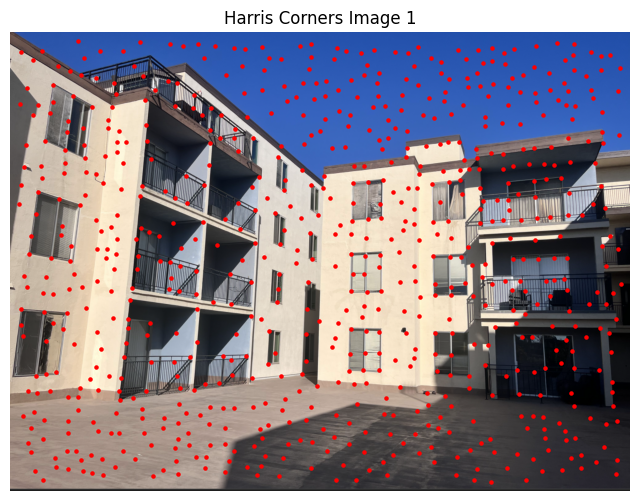

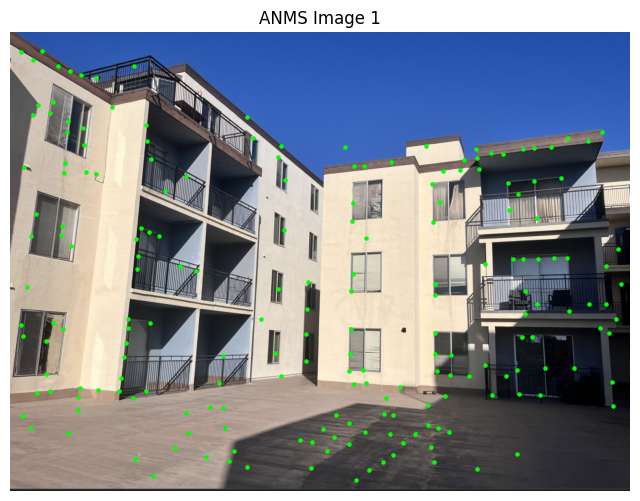

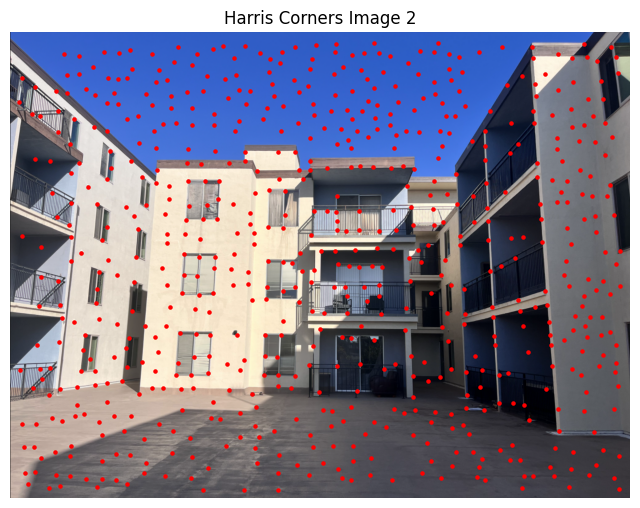

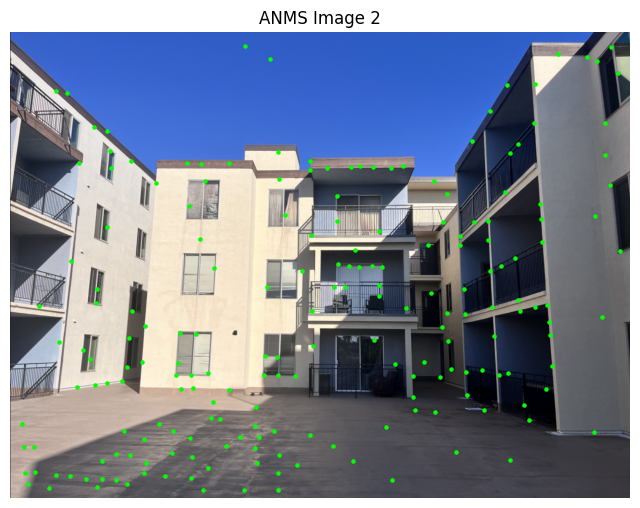

In [105]:
im1_gray = cv2.imread('../left.png', cv2.IMREAD_GRAYSCALE)
im1_color = cv2.imread('../left.png', cv2.IMREAD_COLOR)
im1_color = cv2.cvtColor(im1_color, cv2.COLOR_BGR2RGB)
im1 = im1_gray.astype(float) / 255.0
h1, coords1 = get_harris_corners(im1, min_distance=20)
corner_strengths1 = h1[coords1[:, 0], coords1[:, 1]]
plt.figure(figsize=(8, 8))
plt.imshow(im1_color)
plt.scatter(coords1[:, 1], coords1[:, 0], s=5, c='r')
plt.title("Harris Corners Image 1")
plt.axis('off')
plt.show()
anms_coords1, anms_r1 = anms(coords1, corner_strengths1, num_points=200)
plt.figure(figsize=(8, 8))
plt.imshow(im1_color)
plt.scatter(anms_coords1[:, 1], anms_coords1[:, 0], s=5, c='lime')
plt.title("ANMS Image 1")
plt.axis('off')
plt.show()


im2_gray = cv2.imread('../middle.png', cv2.IMREAD_GRAYSCALE)
im2_color = cv2.imread('../middle.png', cv2.IMREAD_COLOR)
im2_color = cv2.cvtColor(im2_color, cv2.COLOR_BGR2RGB)
im2 = im2_gray.astype(float) / 255.0
h2, coords2 = get_harris_corners(im2, min_distance=20)
corner_strengths2 = h2[coords2[:, 0], coords2[:, 1]]
plt.figure(figsize=(8, 8))
plt.imshow(im2_color)
plt.scatter(coords2[:, 1], coords2[:, 0], s=5, c='r')
plt.title("Harris Corners Image 2")
plt.axis('off')
plt.show()
anms_coords2, anms_r2 = anms(coords2, corner_strengths2, num_points=200)
plt.figure(figsize=(8, 8))
plt.imshow(im2_color)
plt.scatter(anms_coords2[:, 1], anms_coords2[:, 0], s=5, c='lime')
plt.title("ANMS Image 2")
plt.axis('off')
plt.show()

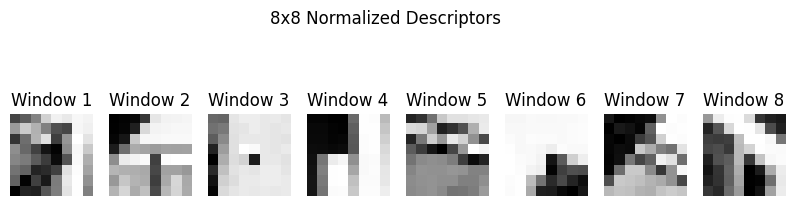

In [113]:


def extract_descriptors(im, keypoints, patch_size=40, desc_size=8):
    descriptors = []
    valid_coords = []
    half_patch = patch_size // 2

    for (y, x) in keypoints:
        if (y - half_patch < 0 or y + half_patch >= im.shape[0] or
            x - half_patch < 0 or x + half_patch >= im.shape[1]):
            continue
        # 40 x 40
        patch = im[y - half_patch:y + half_patch, x - half_patch:x + half_patch]
        # 8 x 8
        small_patch = cv2.resize(patch, (desc_size, desc_size), interpolation=cv2.INTER_AREA)
        small_patch = (small_patch - small_patch.mean()) / small_patch.std()

        descriptors.append(small_patch.flatten())
        valid_coords.append([y, x])

    return np.array(descriptors), np.array(valid_coords)

descriptors1, valid_coords1 = extract_descriptors(im1_gray, anms_coords1)


n_show = 8
fig, axs = plt.subplots(1, n_show, figsize=(10, 3))
for i in range(n_show):
    axs[i].imshow(descriptors1[i].reshape(8, 8), cmap='gray')
    axs[i].set_title(f"Window {i+1}")
    axs[i].axis('off')
plt.suptitle("8x8 Normalized Descriptors")
plt.show()


B.2

In [107]:

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


def match_features_euclidean(descriptors1, descriptors2, thresh=0.75):
    matches = []
    dists = dist2(descriptors1, descriptors2)

    for i in range(dists.shape[0]):
        nn_idx = np.argsort(dists[i])[:2]
        d1, d2 = dists[i, nn_idx[0]], dists[i, nn_idx[1]]

        if d1 < (thresh ** 2) * d2: 
            matches.append((i, nn_idx[0]))

    return matches


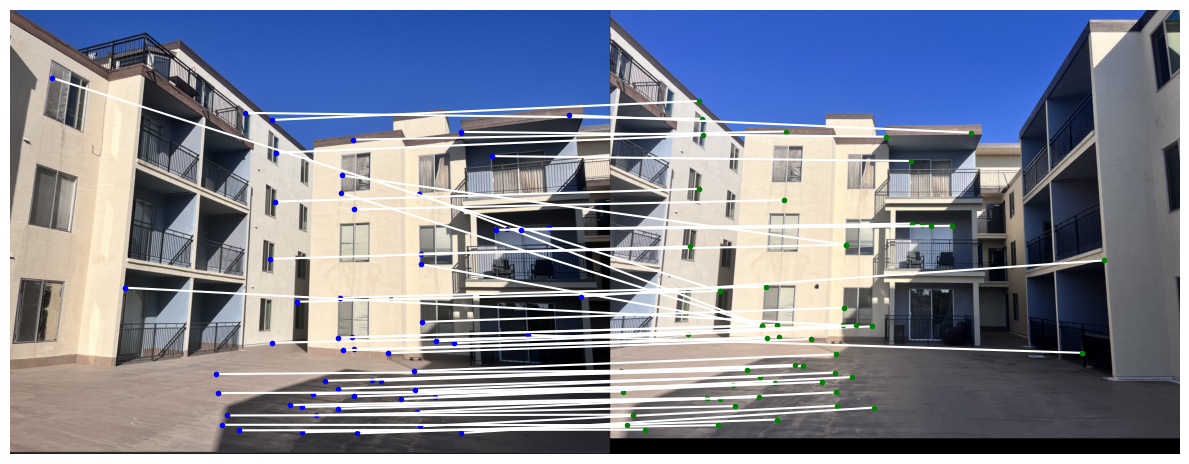

In [108]:
descriptors2, valid_coords2 = extract_descriptors(im2, anms_coords2)
matches = match_features_euclidean(descriptors1, descriptors2, thresh=0.75)

def plot_correspondences(img1, img2, coords1, coords2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    if img1.ndim == 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    if img2.ndim == 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1 + w2] = img2

    plt.figure(figsize=(12, 6))
    plt.imshow(canvas)

    for i1, i2 in matches:
        y1, x1 = coords1[i1]
        y2, x2 = coords2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], 'w-')
        plt.plot(x1, y1, 'bo', markersize=3)
        plt.plot(x2 + w1, y2, 'go', markersize=3)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_correspondences(im1_color, im2_color, anms_coords1, anms_coords2, matches)


In [109]:
def computeH(im1_pts, im2_pts):
    system = []
    for i in range(im1_pts.shape[0]):
        x, y = im1_pts[i]
        x_prime, y_prime = im2_pts[i]
        # y, x = im1_pts[i]
        # y_prime, x_prime = im2_pts[i]

        system.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        system.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    system = np.array(system)


    _, _, out = np.linalg.svd(system)
    h = out[-1, :]
    H = h.reshape((3, 3))

    #9th entry must be 1
    H = H / H[2, 2]
    return H

In [110]:
def ransac_homography(matches, coords1, coords2, epsilon=5.0):
    max_inliers = []

    pts1 = np.array([coords1[i] for i, _ in matches])
    pts2 = np.array([coords2[j] for _, j in matches])
    pts1 = pts1[:, ::-1]
    pts2 = pts2[:, ::-1]

    for i in range(2000):
        idx = np.random.choice(len(matches), 4, replace=False)
        p1_sample = pts1[idx]
        p2_sample = pts2[idx]

        H = computeH(p1_sample, p2_sample)

        p1_h = np.hstack([pts1, np.ones((len(pts1), 1))])
        p2_proj = (H @ p1_h.T).T
        p2_proj = p2_proj / p2_proj[:, 2][:, None]
        dists = np.linalg.norm(p2_proj[:, :2] - pts2, axis=1)

        inliers = np.where(dists < epsilon)[0]

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = H

    best_H = computeH(pts1[max_inliers], pts2[max_inliers])
    return best_H, max_inliers


In [111]:
def warpImageBilinear(im, H, output_shape=None):
    H_inv = np.linalg.inv(H)
    h_out, w_out = output_shape if output_shape else im.shape[:2]
    if im.ndim == 3:
        channels = im.shape[2]
    else:
        channels = 1
    warped = np.zeros((h_out, w_out, channels), dtype=im.dtype)

    for y_out in range(h_out):
        for x_out in range(w_out):
            out = np.array([x_out, y_out, 1])
            in_c = H_inv @ out
            in_c /= in_c[2]

            x_in, y_in = in_c[0], in_c[1]

            if 0 <= x_in < im.shape[1] - 1 and 0 <= y_in < im.shape[0] - 1:
                x0, y0 = int(np.floor(x_in)), int(np.floor(y_in))
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = x_in - x0, y_in - y0

                if channels > 1:
                    top = (1 - dx) * im[y0, x0] + dx * im[y0, x1]
                    bottom = (1 - dx) * im[y1, x0] + dx * im[y1, x1]
                else:
                    top = (1 - dx) * im[y0, x0] + dx * im[y0, x1]
                    bottom = (1 - dx) * im[y1, x0] + dx * im[y1, x1]

                interped = (1 - dy) * top + dy * bottom
                warped[y_out, x_out] = interped

    return warped.squeeze()


def warp(im, H, output_shape, offset):
    H_offset = np.array([[1, 0, -offset[0]],
                         [0, 1, -offset[1]],
                         [0, 0, 1]]) @ H

    return warpImageBilinear(im, H_offset, output_shape)


def create_alpha_mask(shape):
    h, w = shape[:2]
    y_vals = np.arange(0, h)
    x_vals = np.arange(0, w)
    y, x = np.meshgrid(y_vals, x_vals, indexing='ij')
    cx, cy = w / 2, h / 2

    dist = np.sqrt((x - cx)**2 + (y - cy)**2)
    max_dist = np.sqrt((cx)**2 + (cy)**2)

    alpha = 1 - (dist / max_dist)
    alpha = np.clip(alpha, 0, 1)
    return alpha



def blend_images(im1, im2, H):
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]

    corners1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]])
    corners1 = np.hstack([corners1, np.ones((4, 1))])
    warped1 = (H @ corners1.T).T
    warped1 = warped1 / warped1[:, [2]]
    corners2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]])

    x_values = np.hstack([warped1[:, 0], corners2[:, 0]])
    y_values = np.hstack([warped1[:, 1], corners2[:, 1]])

    min_x = int(np.floor(x_values.min()))
    max_x = int(np.ceil(x_values.max()))
    min_y = int(np.floor(y_values.min()))
    max_y = int(np.ceil(y_values.max()))
    width = max_x - min_x
    height = max_y - min_y
    offset = (min_x, min_y)

    warped_im1 = warp(im1, H, (height, width), offset)
    alpha1 = create_alpha_mask(im1.shape)
    alpha1 = warp(np.expand_dims(alpha1, axis=2), H, (height, width), offset)
    if alpha1.ndim == 2:
        alpha1 = np.expand_dims(alpha1, axis=2)

    valid_mask1 = np.any(warped_im1 > 0, axis=2, keepdims=True).astype(np.float32)
    alpha1 *= valid_mask1


    canvas_im2 = np.zeros_like(warped_im1)
    alpha2 = create_alpha_mask(im2.shape)

    x_off, y_off = -min_x, -min_y
    canvas_im2[y_off:y_off + im2.shape[0], x_off:x_off + im2.shape[1]] = im2
    canvas_alpha2 = np.zeros((height, width, 1))
    canvas_alpha2[y_off:y_off + im2.shape[0], x_off:x_off + im2.shape[1], 0] = alpha2
    valid_mask2 = np.any(canvas_im2 > 0, axis=2, keepdims=True).astype(np.float32)
    canvas_alpha2 *= valid_mask2

    if alpha1.ndim == 2:
        alpha1 = np.expand_dims(alpha1, axis=2)
    if canvas_alpha2.ndim == 2:
        canvas_alpha2 = np.expand_dims(canvas_alpha2, axis=2)
    weighted_sum = warped_im1 * alpha1 + canvas_im2 * canvas_alpha2
    alpha_sum = alpha1 + canvas_alpha2 + 1e-6  

    blended = weighted_sum / alpha_sum
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    return blended




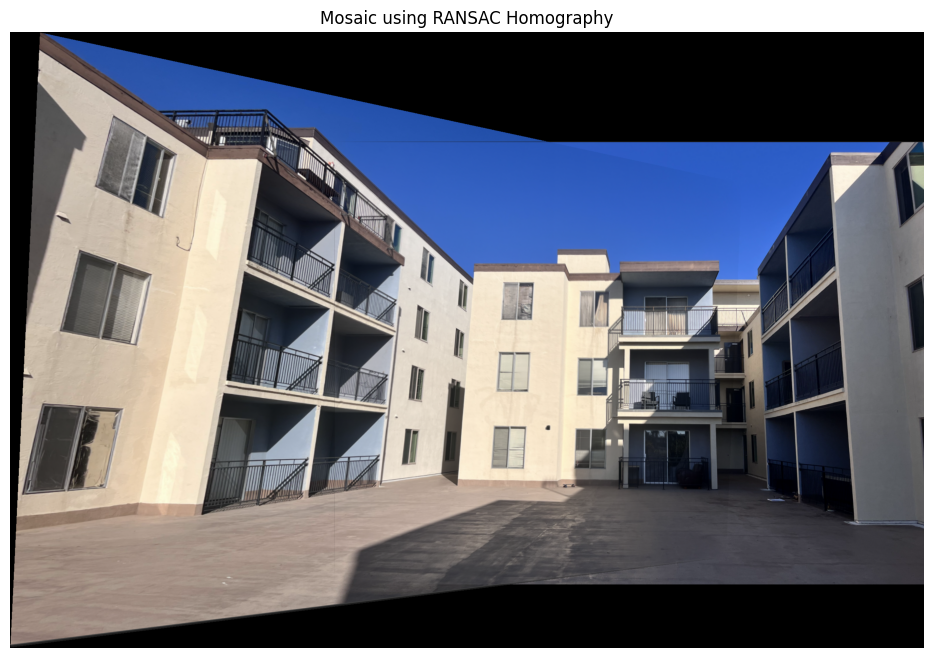

In [112]:
H, inliers = ransac_homography(matches, valid_coords1, valid_coords2)
pts = np.hstack([valid_coords1[:, ::-1], np.ones((len(valid_coords1), 1))])  
proj = (H @ pts.T).T
proj = proj / proj[:, 2][:, None]



mosaic = blend_images(im1_color, im2_color, H)
plt.figure(figsize=(12, 8))
plt.imshow(mosaic)
plt.axis('off')
plt.title("Mosaic using RANSAC Homography")
plt.show()
